<a href="https://colab.research.google.com/github/PincheShackers23/AppCitas/blob/main/EXAMEN_PELICULAS_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HACEMOS TODAS LAS IMPORTACIONES NECESARIAS

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# IMPORTACION DEL DATASET PARA SU POSTERIOR ANALISIS

In [ ]:
movies_dataset = pd.read_csv('movie_data.csv')
sampledata = movies_dataset.sample(20)
movies_dataset

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
...,...,...
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0


# FUNCIONES PRINCIPALES

word_dictionary: Crea un diccionario con las palabras del dataset


In [ ]:
def word_dictionary(data,max_features=10000,maxlen=200):
    '''Crea un diccionario con las palabras del dataset asignando un indice a cada palabra distinta.
    Despues de ello, cambia las palabras del dataset por este index creando un vector de caracteristicas.
    :param data: dataset de datos a vectorizar
    :param max_feactures: Tamaño del diccionario, por defecto se suele utilizar 10000
    :param maxlen: Tamaño maximo del vector
    :return X: Dataset vectorizado
    '''
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(data)
    sequences = tokenizer.texts_to_sequences(data)
    word_index = tokenizer.word_index
    X = pad_sequences(sequences, maxlen=maxlen)
    return X,word_index

In [ ]:
def train_sentiment_analysis_model(data, labels, max_features=10000, maxlen=200, epochs=10, batch_size=128):
    '''Entrena un modelo de análisis de sentimientos utilizando una red neuronal convolucional (CNN)
    :param data: Dataset vectorizado.
    :param labels: Valor objetivo del dataset.
    :param epochs: El número de épocas que se utilizarán para entrenar el modelo. Por defecto se usan 10.
    :param batch_size: El tamaño del lote que se utilizará para entrenar el modelo. Por defecto se usa 128.
    :return model: Modelo entrenado de la red neuronal CNN
    :return cm: Matriz de confusion
    '''
    X = data
    y = labels

    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Definir la arquitectura del modelo
    model = Sequential()
    model.add(Embedding(max_features, 128, input_length=maxlen))
    model.add(Conv1D(32, 7, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    
    #Evaluacion del modelo
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test accuracy:', accuracy)

    # Hacer predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    # Convertir las probabilidades a etiquetas binarias
    y_pred = (y_pred > 0.5).astype(int)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print('Matriz de confusión:')
    print(cm)

    # Devolver el modelo entrenado y el índice de palabras
    return model,cm

In [ ]:
def kfolds_model(data,labels):
  '''Crea un modelo de kfolds para comparar con la red neuronal
  :param data: Dataset de datos de entrenamiento
  :param labels: Etiquetas objetivo
  :return model: Modelo KNN Kfold entrenado '''
  X = pd.DataFrame(data)
  y = labels

  error_cv =[]

  for i in range (0,9):
    kfold = KFold(n_splits = 10, shuffle = True)
    error_folds = []

    for train, test in kfold.split(X,y):
      knn = KNeighborsClassifier(n_neighbors = 8)
      knn.fit(X.iloc[train], y.iloc[train].values.ravel())
      error_folds.append((1 - knn.score(X.iloc[test],y.iloc[test])))

    error_cv.append(np.mean(error_folds))
  print('Error kfolds')
  print(error_cv)
  return knn
 

# MAIN

REALIZAMOS UNA VECTORIZACION DE LAS CRITICAS DEL DATASET

In [ ]:
vectorized_reviews, work_index = word_dictionary(movies_dataset['review'])
vectorized_reviews

array([[8697,    4,   40, ..., 3506,   21, 1292],
       [ 396,    2,   28, ...,   15,    1, 1952],
       [   2,  318,    4, ...,   41,    4,  156],
       ...,
       [   0,    0,    0, ...,  123,  107,  123],
       [   0,    0,    0, ...,   71,    9,    6],
       [   0,    0,    0, ...,  121,    2,  172]], dtype=int32)

CREACION Y ENTRENAMIENTO DEL MODELO DE LA RED NEURONAL CNN

In [ ]:
model,cm = train_sentiment_analysis_model(vectorized_reviews,movies_dataset['sentiment'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 194, 32)           28704     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,308,737
Trainable params: 1,308,737
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
313/313 [==============================] - 77s 241ms/step - loss: 0.5260 - accuracy: 0.7455 - va

ENTRENAMIENTO DEL METODO KFOLDS


error del modelo

In [ ]:
knn = kfolds_model(vectorized_reviews,movies_dataset['sentiment'])

Error kfolds
[0.49676, 0.49607999999999997, 0.49558, 0.49768, 0.49601999999999996, 0.49648000000000003, 0.49745999999999996, 0.49568, 0.495]


In [ ]:
Testdata = pd.DataFrame(vectorized_reviews)
Testdata = Testdata.head(20)
review = np.array(movies_dataset['sentiment'].head(20))

In [ ]:
Predicciones ={'review':review}
Predicciones['Kfolds'] = knn.predict(Testdata)
y_pred = model.predict(vectorized_reviews[:20])
y_pred = (y_pred > 0.5).astype(int)
Predicciones['CNN'] = [y[0] for y in y_pred]

1/1 [==============================] - 0s 43ms/step


In [ ]:
Predicciones

{'review': array([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]),
 'Kfolds': array([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0])}

In [ ]:
df_preds=pd.DataFrame(Predicciones)
df_preds

,review,Kfolds,CNN
0,1,1,1
1,0,0,0
2,0,0,0
3,1,1,1
4,0,0,0
5,1,1,1
6,1,0,1
7,1,1,1
8,1,0,1
9,1,0,1


CREACION DE GRAFICA

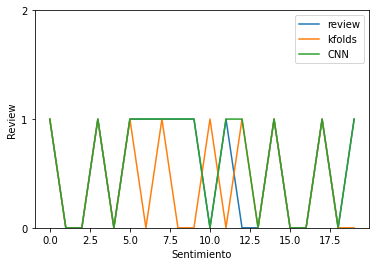

In [ ]:
import matplotlib.pyplot as plt


plt.ylim(0,2)
plt.yticks(np.arange(3), np.arange(3, dtype=int))
# Graficar los datos de la columna 1 como una línea
plt.plot(df_preds["review"], label="review")

# Graficar los datos de la columna 2 como una línea separada
plt.plot(df_preds["Kfolds"], label="kfolds")

plt.plot(df_preds["CNN"], label="CNN")

# Agregar etiquetas de los ejes
plt.xlabel("Sentimiento")
plt.ylabel("Review")

# Agregar una leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

DICCIONARIO DE PALABRAS CREADO

In [ ]:
work_index

{'the': 1,
 'and': 2,
 'a': 3,
 'of': 4,
 'to': 5,
 'is': 6,
 'br': 7,
 'in': 8,
 'it': 9,
 'i': 10,
 'this': 11,
 'that': 12,
 'was': 13,
 'as': 14,
 'for': 15,
 'with': 16,
 'movie': 17,
 'but': 18,
 'film': 19,
 'on': 20,
 'not': 21,
 'you': 22,
 'are': 23,
 'his': 24,
 'have': 25,
 'be': 26,
 'one': 27,
 'he': 28,
 'all': 29,
 'at': 30,
 'by': 31,
 'an': 32,
 'they': 33,
 'so': 34,
 'who': 35,
 'from': 36,
 'like': 37,
 'or': 38,
 'just': 39,
 'her': 40,
 'out': 41,
 'about': 42,
 'if': 43,
 "it's": 44,
 'has': 45,
 'there': 46,
 'some': 47,
 'what': 48,
 'good': 49,
 'when': 50,
 'more': 51,
 'very': 52,
 'up': 53,
 'no': 54,
 'time': 55,
 'my': 56,
 'even': 57,
 'would': 58,
 'she': 59,
 'which': 60,
 'only': 61,
 'really': 62,
 'see': 63,
 'story': 64,
 'their': 65,
 'had': 66,
 'can': 67,
 'me': 68,
 'well': 69,
 'were': 70,
 'than': 71,
 'much': 72,
 'we': 73,
 'bad': 74,
 'been': 75,
 'get': 76,
 'do': 77,
 'great': 78,
 'other': 79,
 'will': 80,
 'also': 81,
 'into': 82,
 'p